# SerumMetabolomics to Risk Scores
## Framingham Risk Score



### Loading relevant loaders
We combine all relevant data in order to calculate the Framinngham risk score for each individual in the 10K project. We do so by first loading all relevant 10k loaders.

We look only at baseline values for now, and removing outliers.

Starting queue permanent run to be used in the prediction phase

In [1]:
%%capture
import os

import numpy as np
import pandas as pd
import pickle

from LabData.DataLoaders.SerumMetabolomicsLoader import SerumMetabolomicsLoader
from LabData.DataLoaders.BloodTestsLoader import BloodTestsLoader
from LabData.DataLoaders.BodyMeasuresLoader import BodyMeasuresLoader
from LabData.DataLoaders.LifeStyleLoader import LifeStyleLoader
from LabData.DataLoaders.MedicalConditionLoader import MedicalConditionLoader

from LabUtils.addloglevels import sethandlers
from LabQueue.qp import qp, fakeqp

import FraminghamRiskScore
import config_local as cl

# sethandlers()


life_style_ld = LifeStyleLoader().get_data(study_ids='10K', groupby_reg='first', min_col_present=500)
body_meas_ld = BodyMeasuresLoader().get_data(study_ids='10K', groupby_reg='first', min_col_present=500,
                                     norm_dist_capping={'sample_size_frac': 0.95, 'clip_sigmas': 5,
                                                        'remove_sigmas': 8})
blood_test_ld = BloodTestsLoader().get_data(study_ids='10K', groupby_reg='first', min_col_present=500,
                                     norm_dist_capping={'sample_size_frac': 0.95, 'clip_sigmas': 5,
                                                        'remove_sigmas': 8})
med_cond_ld = MedicalConditionLoader().get_data(study_ids='10K', groupby_reg='first', min_col_present=500)

serum_metabol_ld = SerumMetabolomicsLoader().get_data(study_ids='10K', groupby_reg='first', min_col_present=500,
                                                norm_dist_capping={'sample_size_frac': 0.95, 'clip_sigmas': 5, 'remove_sigmas': 8}
                                            , precomputed_loader_fname='metab_10k_data_RT_clustering')

### Variables
Assigning variables to each risk score feature.

Disregarding the 'Date' index, as we only look at baseline for now, and dropping all nan values

TODO: diabetes column, and whether a participant is treated for sbp

In [2]:
smoke = life_style_ld.df.smoke_tobacco_now.droplevel(['Date']).dropna()
systolic = body_meas_ld.df.sitting_blood_pressure_systolic.droplevel(['Date']).dropna()
hdl = blood_test_ld.df.bt__hdl_cholesterol.droplevel(['Date']).dropna()
cholesterol = blood_test_ld.df.bt__total_cholesterol.droplevel(['Date']).dropna()
age = body_meas_ld.df_metadata.age.droplevel(['Date']).dropna()
gender = body_meas_ld.df_metadata.gender.droplevel(['Date']).dropna()
# diabetes

### Concatenation and calculation
We concat all features into a single DataFrame, and apply the Framingham Risk Score calculation to each row.

The order of concatenation is important, as the risk score function is static in that way. The diabetes score should come after at the 6^th^ index, and maybe in the future we will add treated sbp

In [3]:
frs = pd.concat([gender, age, cholesterol, hdl, systolic, smoke], axis=1)
frs = frs.dropna()
frs[['frs_score', 'frs_percent_risk']] = frs.apply(FraminghamRiskScore._calculate_framingham_risk_score, axis = 1, result_type="expand")
frs.sort_values(by=['gender','frs_percent_risk'], ascending=False)

,gender,age,bt__total_cholesterol,bt__hdl_cholesterol,sitting_blood_pressure_systolic,smoke_tobacco_now,frs_score,frs_percent_risk
RegistrationCode,,,,,,,,
10K_1019625838,1.0,72.0,161.0,48.0,137.0,0.0,18.0,35.0
10K_1038285016,1.0,71.0,294.0,55.0,159.0,0.0,21.0,35.0
10K_1050950469,1.0,67.0,173.0,42.0,140.0,0.0,18.0,35.0
10K_1122013348,1.0,50.0,176.8,39.0,141.0,-1.0,18.0,35.0
10K_1123361765,1.0,67.0,196.7,48.0,128.0,1.0,19.0,35.0
...,...,...,...,...,...,...,...,...
10K_3774163126,0.0,38.0,152.0,74.0,83.0,0.0,-3.0,0.0
10K_3917700977,0.0,28.0,123.0,66.0,107.0,0.0,-5.0,0.0
10K_6574486945,0.0,31.0,150.0,67.0,124.0,0.0,-2.0,0.0


### Calculating Hard ASCVD Risk Score

In [30]:
ascvd_all_features = cl.load_pickle(os.path.join(cl.PREDICTIONS_PATH,'SM_to_ASCVD_no_perm','ascvd_percent_risk','risk_features.pickle'))
ascvd_risk_score = ascvd_all_features['ascvd_percent_risk']
cl.save_pickle(ascvd_risk_score, os.path.join(cl.DB_PATH, 'RiskScores', 'y'), 'ascvd.pickle')

In [26]:
import HardASCVDRiskScore
ascvd = pd.concat([gender, age, cholesterol, hdl, systolic, smoke], axis=1)
ascvd = ascvd.dropna()
ascvd[['ascvd_percent_risk']] = ascvd.apply(HardASCVDRiskScore.HardASCVDRiskScore, axis = 1, args = [1, 0, 5, 4, 2, 3], result_type="expand")
# cl.save_pickle(ascvd, os.path.join(cl.PREDICTIONS_PATH,'SM_to_ASCVD_no_perm','ascvd_percent_risk'),'risk_features.pickle')

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

### Plots
Plotting the different scoring points for females and males.

<AxesSubplot:xlabel='percent_risk', ylabel='Count'>

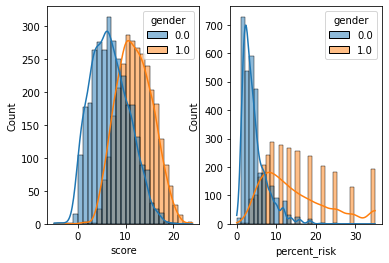

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2)
sns.histplot(frs, x='score', hue='gender', binwidth=1, kde=True, ax=ax[0])
sns.histplot(frs, x='percent_risk', hue='gender', kde=True, ax=ax[1])
# plt.savefig(os.path.join(cl.PLOTS_PATH,'frs_dist'))

[Text(0.5, 1.0, 'Hard ASCVD Risk Score')]

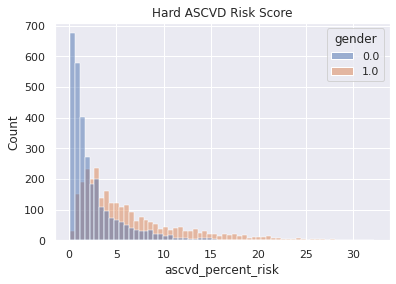

In [61]:
sns.histplot(data = ascvd, x='ascvd_percent_risk', hue='gender').set(title='Hard ASCVD Risk Score')

### SerumMetabolomics load
Load the DataFrame, and reindex to 'RegistrationCode' so it will be compatible with the risk score features indices. It works if you only have one serum per participant, so in baseline it should be fine

In [5]:
if(serum_metabol_ld.df.index.equals(serum_metabol_ld.df_metadata.index)):
    serum_metabol_df = serum_metabol_ld.df
    serum_metabol_df.index = serum_metabol_ld.df_metadata['RegistrationCode']
serum_metabol_df

sm_columns_metadata = serum_metabol_ld.df_columns_metadata

Drop all columns with less than 10 unique values

In [6]:
serum_metabol_df = serum_metabol_df[[c for c in serum_metabol_df.columns if serum_metabol_df[c].nunique() > 9]]

### Building the prediction notation matrices
Configuring the output directory with the local config file

In [312]:
import config_local as cl
y_df = ascvd#frs[['percent_risk', 'score']]
x = serum_metabol_df
# x = pd.concat([serum_metabol_df, age, gender], axis=1, join='inner')
x = x.reindex(y_df.index).dropna(how='all')
y_df = y_df.reindex(x.index)

out_dir = os.path.join(cl.PREDICTIONS_PATH, 'SM_to_ASCVD_no_perm')

### Adjusting for age + gender

In [139]:

y_df = ascvd#frs[['percent_risk', 'score']]
x = serum_metabol_df
# x = pd.concat([serum_metabol_df, age, gender], axis=1, join='inner')
x = x.reindex(y_df.index).dropna(how='all')
y_df = y_df.reindex(x.index)

out_dir = os.path.join(cl.PREDICTIONS_PATH, 'SM_age_gender_to_ASCVD_no_perm')

### Saving matrices as pickles to out_dir

In [141]:
# out_dir = os.path.join(cl.PREDICTIONS_PATH, 'SM_to_FRS')
x_path = os.path.join(out_dir, 'x_df.pickle')
y_path = os.path.join(out_dir, 'y_df.pickle')
frs_feature_path = os.path.join(out_dir)
cl.save_pickle(ascvd, frs_feature_path, 'y_ascvd_features')
cl.save_pickle(x, out_dir, 'x_df.pickle')
cl.save_pickle(y_df, out_dir, 'y_df.pickle')

### Prediction model
Using the LGBM local function to train a tree model to predict both fsr outcome (risk percentage and points), with permutation tests included

In [324]:
out_dir = os.path.join(cl.PREDICTIONS_PATH, 'SM_to_RiskScores_Jupyter')
x = serum_metabol_df
y_df = indices

In [325]:
%%capture
import LGBM


# y_df = indices
#
results =[]
indx = []
for i, y_col in enumerate(y_df.columns): #(y_df.columns.to_list()):
    y = y_df[y_col].dropna()
    x = x.reindex(y.index).dropna(how='all')
    y = y.reindex(x.index)
    results.append(LGBM.LGBMPredict(x, y, out_dir, do_permutations=False))
    indx.append(y_col)

results
# results = LGBM.LGBMPredict(x, y_df['score'], out_dir, do_permutations=False)

### Converting results to DF

In [95]:
results_df = pd.DataFrame(results)
results_df.columns = ['x_train', 'x_test', 'y_train', 'y_test', 'y_pred', 'model',
                   'metrics_dict', 'permutation_results', 'is_signal']
results_df

,x_train,x_test,y_train,y_test,y_pred,model,metrics_dict,permutation_results,is_signal
0,Lipids_NEG_213.0551_31.1470_...,Lipids_NEG_213.0551_31.1470_...,ascvd_percent_risk Registrat...,ascvd_percent_risk Registrat...,ascvd_percent_risk Registrat...,"LGBMRegressor(bagging_fraction=0.9, bagging_fr...",{'Coefficient_of_determination': 0.38904231252...,None,None


In [125]:
import lightgbm as lgb
model = results_df.model[0]
model = lgb.Booster(model_str=model).model_from_string(model_str=model)
model

AttributeError: 'LGBMRegressor' object has no attribute 'encode'

### Plotting results

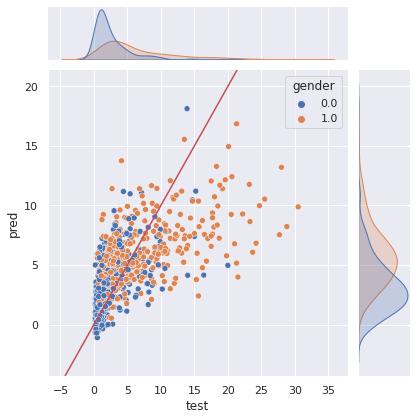

In [132]:
import seaborn as sns

ascvd_data = pd.concat([results_df.y_test[0],results_df.y_pred[0], ascvd.gender],join = 'outer', axis=1)
ascvd_data.columns=['test','pred','gender']
g = sns.jointplot(data=ascvd_data, x='test',y='pred', hue='gender')
g.set_axis_labels('test', 'pred')

g.ax_joint.axline([0,0],[1,1], color='r', label='Identity')
# ascvd_data

# Trash

In [3]:
import os

import SendToQueue
import config_local as cl

out_dir = os.path.join(cl.PREDICTIONS_PATH, 'SM_to_FRS')
x_path = os.path.join(out_dir, 'x_df.pickle')
y_path = os.path.join(out_dir, 'y_df.pickle')

results = SendToQueue.SendToLGBM(x_path=x_path, y_path=y_path, out_dir=out_dir, do_permutations=False)

ValueError: ctypes objects containing pointers cannot be pickled

# Trash



In [103]:
import ResultsAnalysis
import config_local as cl

y_pred_sm_to_fsr = pd.read_csv(os.path.join(cl.PREDICTIONS_PATH, 'SM_to_FRS','score_no_perm','y_pred.csv'))
# y_pred_sm_to_fsr = pd.read_csv(os.path.join(cl.PREDICTIONS_PATH, 'SM_to_FRS','score','y_pred.csv'))
y_test_sm_to_fsr = pd.read_csv(os.path.join(cl.PREDICTIONS_PATH, 'SM_to_FRS','score_no_perm','y_test.csv'))
metrics_sm_to_fsr =pd.read_csv(os.path.join(cl.PREDICTIONS_PATH, 'SM_to_FRS','score_no_perm','results.csv'))

y_features = cl.load_pickle(path=os.path.join(cl.PREDICTIONS_PATH, 'SM_to_FRS','y_frs_features'))

y_test_sm_to_fsr.index = y_test_sm_to_fsr[y_test_sm_to_fsr.columns[0]]
y_test_sm_to_fsr = y_test_sm_to_fsr.drop(columns=y_test_sm_to_fsr.columns[0])
# change column name
y_pred_sm_to_fsr=y_pred_sm_to_fsr.rename(columns={'score':'score_pred'})
y_pred_sm_to_fsr.index = y_pred_sm_to_fsr[y_pred_sm_to_fsr.columns[0]]
y_pred_sm_to_fsr = y_pred_sm_to_fsr.drop(columns=y_pred_sm_to_fsr.columns[0])
# y_test_sm_to_fsr = y_test_sm_to_fsr.score
# y_pred_sm_to_fsr = y_pred_sm_to_fsr.score

data = pd.concat([y_features, y_pred_sm_to_fsr], join='inner', axis = 1)
data
# y_test_sm_to_fsr.index.equals(y_features.index)

,gender,age,bt__total_cholesterol,bt__hdl_cholesterol,sitting_blood_pressure_systolic,smoke_tobacco_now,score,percent_risk,score_pred
RegistrationCode,,,,,,,,,
10K_1003113258,1.0,50.0,155.0,48.0,144.0,0.0,12.0,13.2,10.817430
10K_1012289523,0.0,44.0,251.1,101.0,112.0,0.0,3.0,2.0,2.834668
10K_1033161300,0.0,45.0,186.0,57.0,102.0,0.0,2.0,1.7,3.420259
10K_1038285016,1.0,71.0,294.0,55.0,159.0,0.0,21.0,35.0,14.495284
10K_1046354748,1.0,47.0,139.0,35.0,131.0,0.0,10.0,9.4,11.724558
...,...,...,...,...,...,...,...,...,...
10K_9961235167,1.0,42.0,121.8,30.0,133.0,0.5,14.0,18.4,11.819516
10K_9966025874,0.0,50.0,199.8,60.0,122.0,0.0,7.0,3.9,6.181820
10K_9971099442,1.0,57.0,194.0,69.0,117.0,0.0,9.0,7.9,12.848280


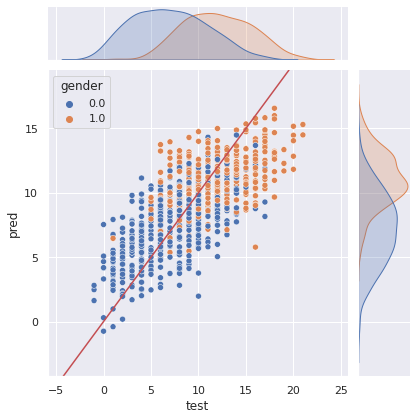

In [113]:
import seaborn as sns
sns.set_theme()
g = sns.jointplot(data=data, x='score',y='score_pred', hue='gender')
g.set_axis_labels('test', 'pred')

g.ax_joint.axline([0,0],[1,1], color='r', label='Identity')

# g.savefig(os.path.join(cl.PLOTS_PATH,'fsr_scatter_plot'))

In [12]:
# serum_metabol_df['Lipids_POS_665.5777_402.2528_302.7531']

In [13]:
# hdl.loc['10K_1248233578']

In [14]:
# sm_columns_metadata = serum_metabol_ld.df_columns_metadata
# sm_columns_metadata.RT_sub_cluster.nunique()
# y_df

'/net/mraid08/export/genie/LabData/Analyses/galavner/Predictions/SM_to_FRS_no_perm'

'/net/mraid08/export/genie/LabData/Analyses/galavner/Predictions/SM_to_FRS_no_perm'

In [15]:
out_dir

'/net/mraid08/export/genie/LabData/Analyses/galavner/Predictions/SM_to_FRS_no_perm'

In [33]:
import config_local as cl
import ResultsAnalysis
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_score = cl.load_pickle(os.path.join(out_dir,'score','y_pred.pickle'))
y_pred_score=y_pred_score.rename(columns={'score':'score_pred'})

y_pred_risk_perc = cl.load_pickle(os.path.join(out_dir,'percent_risk','y_pred.pickle'))
y_pred_risk_perc=y_pred_risk_perc.rename(columns={'percent_risk':'percent_risk_pred'})

y_features = cl.load_pickle(path=os.path.join(cl.PREDICTIONS_PATH, 'SM_to_FRS','y_frs_features'))
data_2 = pd.concat([y_features, y_pred_score, y_pred_risk_perc], join='inner', axis = 1)

metrics_score = cl.load_pickle(os.path.join(out_dir,'score','results.pickle'))
metrics_risk_perc = cl.load_pickle(os.path.join(out_dir,'percent_risk','results.pickle'))

data_2['score_diff'] = data_2['score'] - data_2['score_pred']
data_2['percent_risk_diff'] = data_2['percent_risk'] - data_2['percent_risk_pred']
data_2

,gender,age,bt__total_cholesterol,bt__hdl_cholesterol,sitting_blood_pressure_systolic,smoke_tobacco_now,score,percent_risk,score_pred,percent_risk_pred,score_diff,percent_risk_diff
RegistrationCode,,,,,,,,,,,,
10K_1003113258,1.0,50.0,155.0,48.0,144.0,0.0,12.0,13.2,9.973649,10.881540,2.026351,2.318460
10K_1012289523,0.0,44.0,251.1,101.0,112.0,0.0,3.0,2.0,2.066073,1.803697,0.933927,0.196303
10K_1033161300,0.0,45.0,186.0,57.0,102.0,0.0,2.0,1.7,4.268081,6.933555,-2.268081,-5.233555
10K_1038285016,1.0,71.0,294.0,55.0,159.0,0.0,21.0,35.0,13.691418,18.861736,7.308582,16.138264
10K_1046354748,1.0,47.0,139.0,35.0,131.0,0.0,10.0,9.4,11.860169,16.647659,-1.860169,-7.247659
...,...,...,...,...,...,...,...,...,...,...,...,...
10K_9947884210,1.0,52.0,221.0,47.0,161.0,0.0,15.0,21.6,12.434055,15.919373,2.565945,5.680627
10K_9951847394,0.0,52.0,178.0,57.0,131.0,0.0,8.0,4.5,8.784191,7.411917,-0.784191,-2.911917
10K_9966025874,0.0,50.0,199.8,60.0,122.0,0.0,7.0,3.9,6.066538,3.870037,0.933462,0.029963


Text(10, 10, '0.6612113668069398')

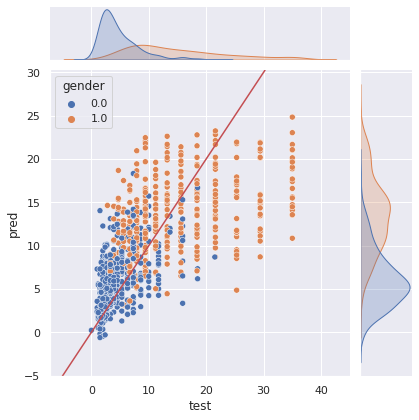

In [179]:
sns.set_theme()
g = sns.jointplot(data=data_2, x='percent_risk',y='percent_risk_pred', hue='gender')
g.set_axis_labels('test', 'pred')
g.ax_joint.axline([0,0],[1,1], color='r', label='Identity')
# g.ax_joint.text(metrics_risk_perc.pearson_r)
plt.annotate(metrics_risk_perc.pearson_r[0], xy = (40,40))

<AxesSubplot:xlabel='percent_risk_diff', ylabel='Count'>

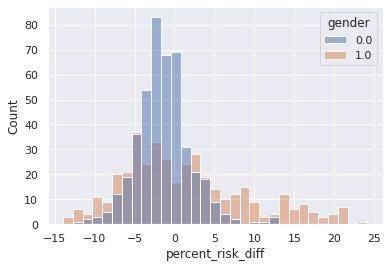

In [34]:
sns.histplot(data = data_2, x='percent_risk_diff', hue='gender')

<AxesSubplot:xlabel='score_diff', ylabel='Count'>

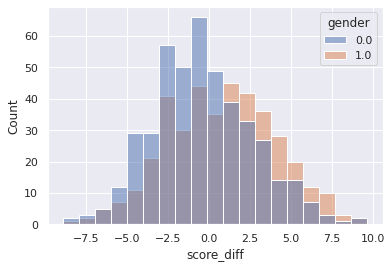

In [35]:
sns.histplot(data = data_2, x='score_diff', hue='gender')

In [54]:
male_indx_score = data_2.loc[data_2['gender']==1][['score', 'score_pred']]
female_indx_score = data_2.loc[data_2['gender']==0][['score', 'score_pred']]
male_indx_perc_risk = data_2.loc[data_2['gender']==1][['percent_risk', 'percent_risk_pred']]
female_indx_perc_risk = data_2.loc[data_2['gender']==0][['percent_risk', 'percent_risk_pred']]

male_indx_perc_risk.corr()
# female_indx_perc_risk.corr()
# data_2[['percent_risk', 'percent_risk_pred_pred']].corr()

,percent_risk,percent_risk_pred
percent_risk,1.00000,0.38572
percent_risk_pred,0.38572,1.00000


<AxesSubplot:>

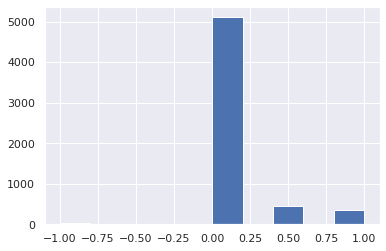

In [52]:
y_features.smoke_tobacco_now.hist()

In [71]:
y_df

,gender,age,bt__total_cholesterol,bt__hdl_cholesterol,sitting_blood_pressure_systolic,smoke_tobacco_now,ascvd_percent_risk
RegistrationCode,,,,,,,
10K_1002087123,0.0,45.0,201.7,38.0,145.0,0.0,1.9
10K_1003113258,1.0,50.0,155.0,48.0,144.0,0.0,3.1
10K_1007699078,1.0,56.0,162.5,51.0,142.0,0.0,5.7
10K_1009247427,0.0,52.0,125.0,31.0,106.0,0.0,1.1
10K_1012289523,0.0,44.0,251.1,101.0,112.0,0.0,0.3
...,...,...,...,...,...,...,...
10K_9984191583,0.0,51.0,215.0,55.0,119.0,0.0,1.3
10K_9985461404,1.0,68.0,170.0,46.0,131.0,0.0,15.6
10K_9985863396,1.0,69.0,163.6,39.0,157.0,0.0,23.5


# DEXA

In [143]:
from LabData.DataLoaders.DEXALoader import DEXALoader

dxald = DEXALoader().get_data(study_ids='10K', groupby_reg='first', min_col_present=500,
                                     norm_dist_capping={'sample_size_frac': 0.95, 'clip_sigmas': 5,
                                                        'remove_sigmas': 8})

[]


<AxesSubplot:xlabel='body_comp_total_fat_mass', ylabel='Count'>

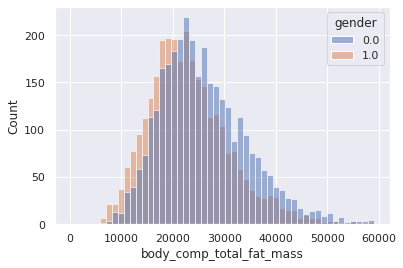

In [159]:
dxa_ind = dxald.df[['total_scan_vat_mass', 'body_comp_total_fat_mass']]
dxa_ind = dxa_ind.droplevel(['Date'])

sns.histplot(data=pd.concat([dxa_ind, gender], axis=1, join='inner'), x='body_comp_total_fat_mass', hue='gender')

In [152]:
out_dir = os.path.join(cl.PREDICTIONS_PATH, 'SM_to_Risk_Scores')
out_dir

'/net/mraid08/export/genie/LabData/Analyses/galavner/Predictions/SM_to_Risk_Scores'

In [195]:

results[1][1]['gender']

data_dxa_body_comp_total_fat_mass = pd.concat([results[0][3], results[0][4], results[0][1]['gender']], axis=1)
data_dxa_body_comp_total_fat_mass.columns = ['body_comp_total_fat_mass', 'body_comp_total_fat_mass_pred', 'gender']
data_dxa_body_comp_total_fat_mass

,body_comp_total_fat_mass,body_comp_total_fat_mass_pred,gender
RegistrationCode,,,
10K_1355867706,646.278690,759.170122,1.0
10K_2520462158,1481.204725,1051.146308,1.0
10K_5480398921,748.548523,921.971780,1.0
10K_2940290348,890.587009,709.665776,0.0
10K_4699919796,1250.714400,1619.787275,1.0
...,...,...,...
10K_5437285183,446.957316,308.044258,0.0
10K_7636028051,97.045437,151.670424,0.0
10K_4255481435,1830.338310,1283.853417,1.0


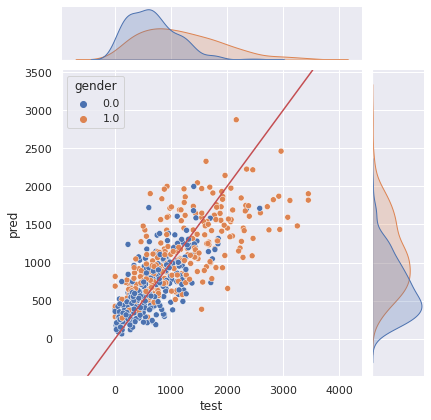

In [196]:
sns.set_theme()
g = sns.jointplot(data=data_dxa_body_comp_total_fat_mass, x='body_comp_total_fat_mass',y='body_comp_total_fat_mass_pred', hue='gender')
g.set_axis_labels('test', 'pred')
g.ax_joint.axline([0,0],[1,1], color='r', label='Identity')

# Building Adiposirt Indices

In [7]:
import Loaders

body_ld = Loaders.get_BodyMeasuresLoaderDF()
dexa_ld = Loaders.get_DEXALoader()


body_df = body_ld.df
body_df = body_df.droplevel(['Date'])

dexa_df = dexa_ld.df
dexa_df = dexa_df.droplevel(['Date'])

[]


In [8]:
visceral_fat_mass = pd.Series(dexa_df['total_scan_vat_mass'], name='visceral_fat_mass')
visceral_fat_area = pd.Series(dexa_df['total_scan_vat_area'], name='visceral_fat_area')
visceral_fat_volume = pd.Series(dexa_df['total_scan_vat_volume'], name='visceral_fat_volume')
waist_to_hip_ratio = pd.to_numeric(pd.Series(body_df['waist'] / body_df['hips'], name='waist_to_hip_ratio'))
fat_mass_index = pd.to_numeric(pd.Series(dexa_df['body_comp_total_fat_mass'] * 0.001 / ((body_df['height'] * 0.01)**2), name='fat_mass_index'))
total_fat_percent = pd.Series(dexa_df['body_comp_total_fat_mass'] / dexa_df['body_comp_total_total_mass'], name='total_fat_percent')
android_gynoid_ratio = pd.Series(dexa_df['body_comp_android_fat_mass'] / dexa_df['body_comp_gynoid_fat_mass'], name='android_gynoid_ratio')
trunk_to_limb_ratio = pd.Series(dexa_df['body_comp_trunk_fat_mass'] / (dexa_df['body_comp_arms_fat_mass'] + dexa_df['body_comp_legs_fat_mass']), name='trunk_to_limb_ratio')
trunk_to_legs_ratio = pd.Series(dexa_df['body_comp_trunk_fat_mass'] / dexa_df['body_comp_legs_fat_mass'], name='trunk_to_legs_ratio')

adiposity_indices = pd.concat([visceral_fat_mass, visceral_fat_volume, visceral_fat_area, waist_to_hip_ratio, fat_mass_index, total_fat_percent, android_gynoid_ratio, trunk_to_limb_ratio, trunk_to_legs_ratio], axis=1)


lean_mass_index = pd.to_numeric(pd.Series((dexa_df['body_comp_total_lean_mass']*0.001) / ((body_df['height']*0.01)**2), name='lean_mass_index'))
appendicular_lean_mass = pd.to_numeric(pd.Series(dexa_df['body_comp_arms_lean_mass'] + dexa_df['body_comp_legs_lean_mass'], name='appendicular_lean_mass'))
appendicular_lean_mass_index = pd.to_numeric(pd.Series((appendicular_lean_mass*0.001 ) / ((body_df['height']*0.01)**2), name='appendicular_lean_mass_index'))

muscle_mass_indices = pd.concat([lean_mass_index, appendicular_lean_mass, appendicular_lean_mass_index], axis=1)

indices = pd.concat([adiposity_indices, muscle_mass_indices], axis=1)

In [24]:
pd.DataFrame(indices['fat_mass_index']).shape#.values.reshape(len(indices['fat_mass_index']),1)
# serum_metabol_df

(8951, 1)

In [12]:
cl.save_pickle(adiposity_indices, os.path.join(cl.DB_PATH, 'RiskScores', 'y'), 'adiposity_indices.pickle')
cl.save_pickle(muscle_mass_indices, os.path.join(cl.DB_PATH, 'RiskScores', 'y'), 'muscle_mass_indices.pickle')


cl.save_pickle(serum_metabol_df, os.path.join(cl.DB_PATH, 'RiskScores', 'x'), 'serum_metabolomics_df.pickle')

In [ ]:
sns.set_theme()
fig, axs = plt.subplots(3,3, figsize=(15,15))

# sns.histplot(data = adiposity_indices, x='total_scan_vat_mass', ax=axs[0,0])
# sns.histplot(data = adiposity_indices, x='total_scan_vat_area', ax=axs[0,1])
# sns.histplot(data = adiposity_indices, x='total_scan_vat_volume', ax=axs[0,2])
sns.histplot(data = adiposity_indices, x='waist_to_hip_ratio', ax=axs[1,0])
sns.histplot(data = adiposity_indices, x='fat_mass_index', ax=axs[1,1])
sns.histplot(data = adiposity_indices, x='total_fat_percent', ax=axs[1,2])
sns.histplot(data = adiposity_indices, x='android_gynoid_ratio', ax=axs[2,0])
sns.histplot(data = adiposity_indices, x='trunk_to_limb_ratio', ax=axs[2,1])
sns.histplot(data = adiposity_indices, x='trunk_to_legs_ratio', ax=axs[2,2])

plt.show()

In [290]:
# sns.histplot(data = adiposity_indices, x='total_scan_vat_mass', kde=True, ax=axs[0,0])
tmp = cl.load_pickle(os.path.join(cl.DB_PATH, 'RiskScores', 'adiposity_indices.pickle'))
type(tmp.waist_to_hip_ratio[220])
# pd.to_numeric(indices.waist_to_hip_ratio).dtypes
indices.shapel

(8891, 12)

In [347]:
for j in range(len(results)):
    print(results[i][6]['pearson_r'])

0.7141207253811437
0.7141207253811437
0.7141207253811437
0.7141207253811437
0.7141207253811437
0.7141207253811437
0.7141207253811437
0.7141207253811437
0.7141207253811437
0.7141207253811437
0.7141207253811437
0.7141207253811437


In [345]:
out_dir

'/net/mraid08/export/genie/LabData/Analyses/galavner/Predictions/SM_to_RiskScores_Jupyter'

In [333]:
cl.save_pickle(results, out_dir,'all_results.pickle')

In [15]:
import os
import glob

os.chdir(os.path.join(cl.PREDICTIONS_PATH))
for file in glob.glob(os.path.join(cl.DB_PATH, 'RiskScores','y',"*.pickle")):
    print(cl.load_pickle(file))


                  lean_mass_index  appendicular_lean_mass  \
RegistrationCode                                            
10K_1000942861          19.685987            30758.968279   
10K_1001201093          13.650202            17051.393450   
10K_1002087123          19.242941            24011.741127   
10K_1003113258                NaN                     NaN   
10K_1007330152          20.849072            25144.312754   
...                           ...                     ...   
10K_9995823183          14.973533            20579.002144   
10K_9996884777          17.896023            21384.303787   
10K_9998418497                NaN                     NaN   
10K_9999226141          17.004837            24904.157101   
10K_9999409119                NaN                     NaN   

                  appendicular_lean_mass_index  
RegistrationCode                                
10K_1000942861                        9.440986  
10K_1001201093                        5.900136  
10K_100208